In [77]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
from IPython import display
import glob
import imageio
from datetime import datetime
from tqdm import tqdm

# Data: rtcor files

In [16]:
# Open radar files in folder radarscans 2018-12-19 08:00 till 2018-12-20 07:55
radar_dir = '/nobackup/users/schreurs/project_GAN/dataset_radar_np'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f))])
print(len(files))

227679


In [14]:
def get_datetime(filename):
    '''
    Infer datetime from filename
    '''
    timestamp=filename.replace('.npy', '')
    try:
        dt = datetime.strptime(timestamp, '%Y%m%d%H%M')
    except:
        print('Error: could not find timestamp in file {}'.format(filename))
    return dt

In [19]:
dates = np.array([get_datetime(f) for f in files[:5]])
dates

array([datetime.datetime(2018, 12, 19, 8, 0),
       datetime.datetime(2018, 12, 19, 8, 5),
       datetime.datetime(2018, 12, 19, 8, 10),
       datetime.datetime(2018, 12, 19, 8, 15),
       datetime.datetime(2018, 12, 19, 8, 20)], dtype=object)

In [89]:
def load_radar(fn):
    '''
    Load the radar as a masked array
    The value 65535 is given to pixels out of the range of the radar
    '''
    rdr = np.load(radar_dir+'/' +fn, allow_pickle=True)
    mask = (rdr == 65535)
    rdr_ma = np.ma.masked_array(rdr, mask=mask)
    return rdr_ma

0 63


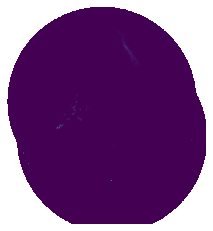

In [80]:
rdr = load_radar(files[0])
print(rdr.min(), rdr.max())
plt.imshow(rdr)
plt.axis('off')
plt.show()

In [90]:
mean_rain = []
for file in tqdm(files):
    date = get_datetime(file)
    rdr = load_radar(file)
    mean_rain.append([date, rdr.mean()])

 13%|█▎        | 29528/227679 [18:31<2:04:15, 26.58it/s] 


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
np_arr = np.array(mean_rain)

In [ ]:
np.save(np_arr,)

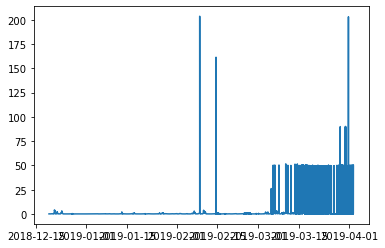

In [87]:
plt.plot(np_arr[:,0], np_arr[:,1])

# Data recor files (outdated)

In [168]:
# Open radar files in folder radarscans 2018-12-19 08:00 till 2018-12-20 07:55
radar_dir = './RAD25_OPER_R___TARRRT__L2__20181219080000_20181220075500_0001/'
onlyfiles = [f for f in listdir(radar_dir) if isfile(join(radar_dir, f))]

The image2 seems to be a binary mask with the lower value being 32768 and the upper value being 65535. Image1 has different value and seems to contain the actual precipitation data

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 27 38 41 42 43 48 62 63]


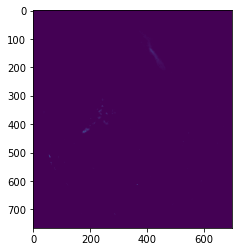

[32768 65535]


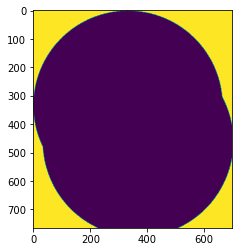

In [169]:
# Plot the image files:
h5f = h5py.File(radar_dir+onlyfiles[0], 'r')

radar_img = np.array(h5f['image1']['image_data'])
# change masked values to 0
radar_img[radar_img == 65535] = 0
plt.imshow(radar_img)
print(np.unique(radar_img.flatten()))
plt.show()

img_mask = np.array(h5f['image2']['image_data'])
print(np.unique(img_mask.flatten()))
plt.imshow(img_mask) # interpolation='none'
plt.show()

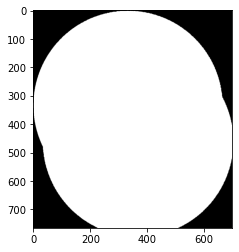

In [170]:
# Create function to obtain binary mask
def get_mask(h5f):
    mask = np.array(h5f['image2']['image_data'])
    mask[mask==32768] = 1
    mask[mask==65535] = 0
    return mask
mask = get_mask(h5f)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.show()

Find the minimum and maximum pixel value

In [171]:
# find max and min value of the radar scans
max_value=0
min_value=0
for i in range(len(onlyfiles)):
    h5f = h5py.File(radar_dir+onlyfiles[0], 'r')
    radar_img = np.array(h5f['image1']['image_data'])
    # change masked values to 0
    radar_img[radar_img == 65535] = 0
    if max(radar_img.flatten()) > max_value:
        max_value = max(radar_img.flatten())
    if min(radar_img.flatten()) < min_value:
        min_value = min(radar_img.flatten())
print('min = {}, max = {}'.format(min_value, max_value))

min = 0, max = 63


In [180]:
def plot_radar(h5file, show_mask=False, fileName=None):
    radar_img = np.array(h5file['image1']['image_data'])
    mask = get_mask(h5file)
    # apply mask to image
    img = radar_img*mask
    plt.imshow(img, vmin=min_value, vmax=max_value)
    plt.axis('off')
    if show_mask:
        plt.imshow(mask, cmap='binary', interpolation='none', alpha=0.2)
    if fileName:
        plt.savefig(fileName, bbox_inches='tight')
        display.clear_output(wait=True)
    plt.show()

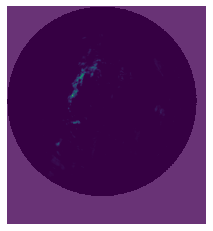

In [183]:
h5f = h5py.File(radar_dir+onlyfiles[-1], 'r')
plot_radar(h5f,show_mask=True, fileName='images/imague{}.png'.format(0))

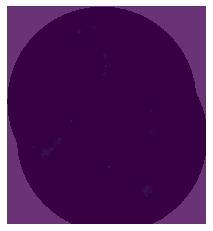

In [184]:
# save radar scans as images
for i in range(len(onlyfiles))[:100]:
    h5f = h5py.File(radar_dir+onlyfiles[i], 'r')
    plot_radar(h5f,show_mask=True, fileName='images/image{}.png'.format(i))

In [185]:
anim_file = 'precipitation.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

A gif of the precipitation is given below


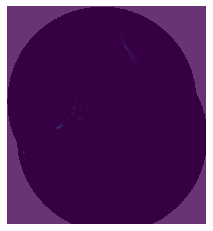

In [186]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)